In [1]:
#! Python3
# by Jacob Kovach
# Confidential and Proprietary

import matplotlib.pyplot as plt, numpy as np, pandas as pd, urllib.request, pickle, spacy, re, os
from nltk import tokenize
from collections import Counter

# Utility for opening files to variables
def get_variables(file):
    with open(file, 'rb') as file:
        return pickle.load(file)
    
# Get common words and dataframe of transcripts
common_words = get_variables('/Users/jkovach/Downloads/earnings-call-transcripts/_common_word_list')
earnings_df = get_variables('/Users/jkovach/Downloads/earnings-call-transcripts/_call_df_500')
earnings_df = earnings_df.drop(['datetime', 'raw', 'filename', 'ticker', 'duration', 'price_delta'], 1)
earnings_df.head()

,content,Movement
0,like turn host today thank join financial resu...,0
1,today schedule hour include remark management ...,2
2,company prepare remark participant listen mode...,1
3,time like welcome incs like ask question time ...,1
4,time participant listen mode later conduct que...,2


Class Balance: [(0, 106), (1, 226), (2, 93)]


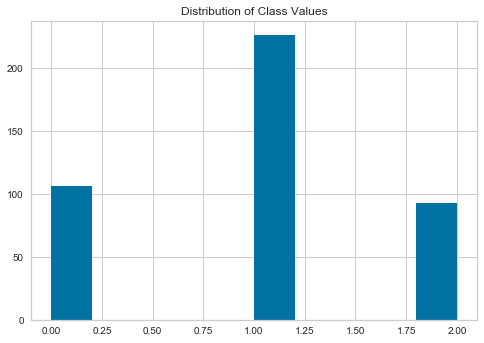

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pron'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches 

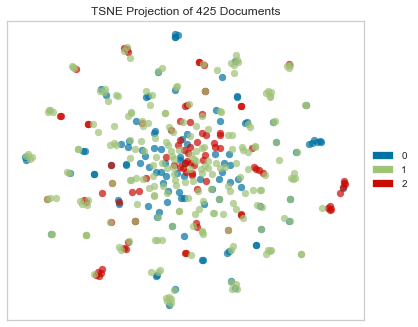

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from yellowbrick.text import TSNEVisualizer

# Declare raw feature text and labels and visualize distribution of classes
corpus = earnings_df['content']
labels = earnings_df['Movement']
print("Class Balance: {}".format(sorted(labels.items())))

plt.figure()
plt.hist(earnings_df.Movement)
plt.title("Distribution of Class Values")
plt.show()

# Load the data and create document vectors
vectorizer = TfidfVectorizer(min_df=4, 
                             stop_words=common_words, 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True,
                             ngram_range=(1,4),
                            )

# Create visualizer and draw the vectors
X = vectorizer.fit_transform(corpus)
tsne = TSNEVisualizer()
tsne.fit(X, labels)
tsne.show()


In [3]:
#Apply the vectorizer and get number of features
earnings_tfidf = vectorizer.fit_transform(corpus)
terms = vectorizer.get_feature_names()
print("Number of features: %d" % earnings_tfidf.shape[1])

#Reduce features from 1098 to 300, run SVD, then project the training data.
svd = TruncatedSVD(300)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_lsa = lsa.fit_transform(earnings_tfidf)

# Get the total explained variance after SVD
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance*100)

# Covert to vectorizer results to dataframe
paras_by_component=pd.DataFrame(X_lsa, index=earnings_df['content'])
paras_by_component=paras_by_component.merge(earnings_df, on='content')
paras_by_component.head()

Number of features: 1098
Percent variance captured by all components: 93.09755887424748


,content,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,Movement
0,like turn host today thank join financial resu...,0.015468,0.093585,0.231902,0.022209,-0.096513,0.389761,0.094546,-0.001723,-0.003638,...,-0.049223,0.014646,-0.069986,0.007627,-0.004933,-0.008463,0.022405,-0.026739,0.001923,0
1,today schedule hour include remark management ...,0.018383,0.071521,0.005152,-0.004943,-0.016372,0.000717,-0.039564,-0.064684,0.041074,...,0.034709,0.003895,-0.023363,0.005880,-0.007212,-0.018032,-0.016882,0.022316,0.039321,2
2,company prepare remark participant listen mode...,0.025236,0.070197,0.010018,-0.002377,-0.003387,0.000527,-0.020990,0.004599,0.009237,...,0.019561,0.052788,-0.006612,-0.005295,-0.038271,0.115413,0.002789,-0.062410,-0.025781,1
3,time like welcome incs like ask question time ...,0.031354,0.089574,-0.007762,-0.013126,-0.020233,-0.008742,-0.019205,-0.004647,-0.026921,...,-0.022829,-0.011697,-0.010597,0.026419,0.045998,-0.051005,-0.036908,-0.081325,-0.014168,1
4,time participant listen mode later conduct que...,0.015510,0.054496,-0.041448,0.093404,0.026318,0.009780,0.009197,0.002094,-0.005484,...,-0.000847,0.037708,-0.018008,-0.003925,-0.029340,-0.019555,-0.101037,0.067559,0.081117,2


Using TensorFlow backend.


Class Balance: [(0, 161), (1, 161), (2, 161)]


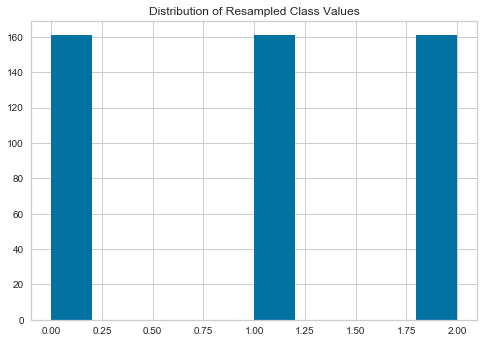

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


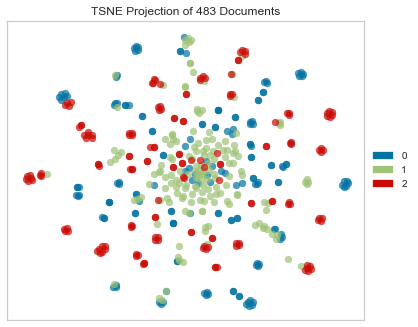

In [4]:
from imblearn.over_sampling import RandomOverSampler 

# Global variables for sampler and split functions
sample_split=0.3
sampler_state = 42

y = paras_by_component['Movement']
X = paras_by_component.drop(['content', 'Movement'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=sample_split,
                                                    random_state=0)

# Instantiate random oversampler and fit the training data
ros = RandomOverSampler(random_state=sampler_state)
X_train_res, y_train_res = ros.fit_sample(X_train, y_train)

# Recheck Class Balance
print("Class Balance: {}".format(sorted(Counter(y_train_res).items())))

plt.figure()
plt.hist(y_train_res)
plt.title("Distribution of Resampled Class Values")
plt.show()

# Visualizer vectors for balanced classes
tsne = TSNEVisualizer()
tsne.fit(X_train_res, y_train_res)
tsne.show()

In [5]:
from sklearn import ensemble
from sklearn import metrics 
from sklearn.model_selection import cross_val_score

# Model selection #1: Random Forest
folds=5
rfc_params = {'n_estimators': 300,
              'max_depth': 5, 
              'max_features': 40}

rfc = ensemble.RandomForestClassifier(**rfc_params)
rfc.fit(X_train_res, y_train_res)
y_pred = rfc.predict(X_test)

print('Training set score:', rfc.score(X_train_res, y_train_res))
print('\nTest set score:', rfc.score(X_test, y_test))
print(cross_val_score(rfc, X_test, y_test, cv=folds))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Training set score: 0.9979296066252588

Test set score: 0.59375
[0.48148148 0.5        0.64       0.56       0.48      ]
              precision    recall  f1-score   support

           0       0.39      0.23      0.29        31
           1       0.61      0.75      0.68        65
           2       0.67      0.62      0.65        32

    accuracy                           0.59       128
   macro avg       0.56      0.53      0.54       128
weighted avg       0.57      0.59      0.57       128

[[ 7 20  4]
 [10 49  6]
 [ 1 11 20]]


In [6]:
# Model selection #2: Gradient Boosting Classifier
gbc_params = {'n_estimators': 300,
              'max_depth': 3, 
              'max_features': 40}

clf = ensemble.GradientBoostingClassifier(**gbc_params)
train = clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

print('Training set score:', clf.score(X_train_res, y_train_res))
print('\nTest set score:', clf.score(X_test, y_test))
print(cross_val_score(clf, X_test, y_test, cv=folds))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Training set score: 1.0

Test set score: 0.6015625
[0.37037037 0.53846154 0.52       0.6        0.6       ]
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        31
           1       0.61      0.82      0.70        65
           2       0.67      0.44      0.53        32

    accuracy                           0.60       128
   macro avg       0.59      0.53      0.54       128
weighted avg       0.60      0.60      0.58       128

[[10 19  2]
 [ 7 53  5]
 [ 3 15 14]]


In [7]:
from sklearn.linear_model import LogisticRegression

# Model selection #3: Linear Regression
lr = LogisticRegression(penalty='l1', solver='saga')
train = lr.fit(X_train_res, y_train_res)
y_pred = lr.predict(X_test)

print('Training set score:', lr.score(X_train_res, y_train_res))
print('\nTest set score:', lr.score(X_test, y_test))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.8778467908902692

Test set score: 0.640625
              precision    recall  f1-score   support

           0       0.54      0.65      0.59        31
           1       0.73      0.55      0.63        65
           2       0.62      0.81      0.70        32

    accuracy                           0.64       128
   macro avg       0.63      0.67      0.64       128
weighted avg       0.66      0.64      0.64       128

[[20  8  3]
 [16 36 13]
 [ 1  5 26]]


In [8]:
from sklearn.svm import LinearSVC

# Model selection #1: Linear Support Vector Classifier
lsvc = LinearSVC(penalty='l1', dual=False)
train = lsvc.fit(X_train_res, y_train_res)
y_pred = lsvc.predict(X_test)

print('Training set score:', lsvc.score(X_train_res, y_train_res))
print('\nTest set score:', lsvc.score(X_test, y_test))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Training set score: 0.989648033126294

Test set score: 0.625
              precision    recall  f1-score   support

           0       0.57      0.55      0.56        31
           1       0.65      0.65      0.65        65
           2       0.64      0.66      0.65        32

    accuracy                           0.62       128
   macro avg       0.62      0.62      0.62       128
weighted avg       0.62      0.62      0.62       128

[[17 14  0]
 [11 42 12]
 [ 2  9 21]]


In [9]:
from sklearn.neighbors import NearestCentroid

# Model selection #5: Nearest Centroid
nc = NearestCentroid()
train = nc.fit(X_train_res, y_train_res)
y_pred = nc.predict(X_test)

print('Training set score:', nc.score(X_train_res, y_train_res))
print('\nTest set score:', nc.score(X_test, y_test))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

Training set score: 0.9585921325051759

Test set score: 0.5546875
              precision    recall  f1-score   support

           0       0.48      0.35      0.41        31
           1       0.56      0.75      0.64        65
           2       0.61      0.34      0.44        32

    accuracy                           0.55       128
   macro avg       0.55      0.48      0.50       128
weighted avg       0.55      0.55      0.54       128

[[11 20  0]
 [ 9 49  7]
 [ 3 18 11]]
